# concanate data 

In [1]:
## load data and funtions 
#########################################################################################
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
# Add the workspace root to the Python path
workspace_root = os.path.abspath("..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess, behaviorAnalysis
with open(os.path.join( workspace_root,'Data', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)

with open(os.path.join( workspace_root, 'Data', 'bad_channels_detected.pkl'), "rb") as f:
    all_bads = pickle.load(f)


def pre_cncat(id):
    bads_channel= all_bads[id]['channel_names']
    bad_trials= all_bads[id]['trial_numbers']
    blink_components = all_bads[id]['ica_blinks']
    bridged_channels= all_bridged_channels[5][id] 
    sub = preprocess(id)
    raw = sub.load_data()
    #############################################################################################
    # 1. remove noisy channels
    raw.info['bads'] = bads_channel
    # 2. Filter the data
    raw.notch_filter([50,100], fir_design='firwin', skip_by_annotation='edge')
    raw.filter(l_freq=1, h_freq= 40)
    # 3. segment the data from stim to response (remove noisy trials and trials with wrong answers)
    events = mne.find_events(raw)
    all_events = sub.get_all_events_times(id, events).dropna()
    new_raw = sub.segment_stimRt(raw, all_events, bad_trials)
    # 4. remove blink components 
    ica_path = os.path.join(workspace_root, 'Data', f'S{id}_ica.fif')
    ica = mne.preprocessing.read_ica(ica_path)
    ica.exclude = blink_components
    ica.apply(new_raw, exclude=blink_components)
    # 5. interpolate bridged channels
    new_raw = mne.preprocessing.interpolate_bridged_electrodes(new_raw, bridged_channels['bridged_idx'], bad_limit=3) 
    # 6. interpolate bad channels
    new_raw.interpolate_bads()
    # 7. rereference the data
    new_raw.set_eeg_reference(ref_channels='average')
    # 8. zscore the data
    data = new_raw.get_data()
    chan_means = np.mean(data, axis=1, keepdims=True)
    chan_stds  = np.std(data,  axis=1, keepdims=True)
    zscored_data = (data - chan_means) / chan_stds
    new_raw._data = zscored_data
    return new_raw



In [17]:
all_bads

{601: {'channel_names': ['D29', 'B27'],
  'trial_numbers': [57, 58, 59, 55, 106],
  'ica_blinks': [0, 5]},
 602: {'channel_names': ['A32'],
  'trial_numbers': [19, 17, 20, 62, 69, 71, 75, 77, 78, 92, 86, 80, 107],
  'ica_blinks': [0, 5]},
 603: {'channel_names': [], 'trial_numbers': [1, 102, 49], 'ica_blinks': [0]},
 604: {'channel_names': ['A31'], 'trial_numbers': [], 'ica_blinks': [0, 1]},
 605: {'channel_names': [],
  'trial_numbers': [55, 6, 19, 20, 21],
  'ica_blinks': [0, 8]},
 606: {'channel_names': [], 'trial_numbers': [], 'ica_blinks': [0]}}

In [18]:
ids = [601,602,603,604,605,606]
all_pregICA = []
for id in ids:
    pregICA = pre_cncat(id)
    all_pregICA.append(pregICA)
combined_pregICA = mne.concatenate_raws(all_pregICA)
# 9. save the data
combined_pregICA_path = os.path.join(workspace_root, 'Data', 'combined_pregICA.fif')
combined_pregICA.save(combined_pregICA_path, overwrite=True)

Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_601_Def_AM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478719  =      0.000 ...   934.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_601_Def_AM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 478719  =      0.000 ...   934.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S601_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (120 components)
    Zeroing out 2 ICA components
    Projecting back using 126 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=127583
    Range : 2835 ... 130417 =      5.537 ...   254.721 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=127583
    Range : 2835 ... 130417 =      5.537 ...   254.721 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=127583
    Range : 2835 ... 130417 =      5.537 ...   254.721 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=127583
    Range : 2835 ... 130417 =   

c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S602_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (114 components)
    Zeroing out 2 ICA components
    Projecting back using 127 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=134093
    Range : 1953 ... 136045 =      3.814 ...   265.713 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134093
    Range : 1953 ... 136045 =      3.814 ...   265.713 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134093
    Range : 1953 ... 136045 =      3.814 ...   265.713 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134093
    Range : 1953 ... 136045 =   

c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S603_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (127 components)
    Zeroing out 1 ICA component
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=115467
    Range : 26591 ... 142057 =     51.936 ...   277.455 secs
Ready.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.6 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 2 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a cust

C:\Users\gmoha\AppData\Local\Temp\ipykernel_4516\2538353112.py:47: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  new_raw.interpolate_bads()


Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_604_Def_LM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 512511  =      0.000 ...  1000.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_604_Def_LM.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 512511  =      0.000 ...  1000.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S604_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (109 components)
    Zeroing out 2 ICA components
    Projecting back using 127 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=134737
    Range : 3652 ... 138388 =      7.133 ...   270.289 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134737
    Range : 3652 ... 138388 =      7.133 ...   270.289 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134737
    Range : 3652 ... 138388 =      7.133 ...   270.289 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=134737
    Range : 3652 ... 138388 =   

c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S605_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (110 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=114973
    Range : 2332 ... 117304 =      4.555 ...   229.109 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114973
    Range : 2332 ... 117304 =      4.555 ...   229.109 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114973
    Range : 2332 ... 117304 =      4.555 ...   229.109 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=114973
    Range : 2332 ... 117304 =   

C:\Users\gmoha\AppData\Local\Temp\ipykernel_4516\2538353112.py:47: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  new_raw.interpolate_bads()


Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_606_Def_YD.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460799  =      0.000 ...   899.998 secs...
Extracting EDF parameters from c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\O_606_Def_YD.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 460799  =      0.000 ...   899.998 secs...


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
108 events found on stim channel Status
Event IDs: [1 2]
Reading c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\S606_ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (117 components)
    Zeroing out 1 ICA component
    Projecting back using 128 PCA components
Creating RawArray with float64 data, n_channels=1, n_times=139059
    Range : 2716 ... 141774 =      5.305 ...   276.902 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=139059
    Range : 2716 ... 141774 =      5.305 ...   276.902 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=139059
    Range : 2716 ... 141774 =      5.305 ...   276.902 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=139059
    Range : 2716 ... 141774 =    

C:\Users\gmoha\AppData\Local\Temp\ipykernel_4516\2538353112.py:47: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  new_raw.interpolate_bads()


Writing c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif


C:\Users\gmoha\AppData\Local\Temp\ipykernel_4516\1789425246.py:9: RuntimeWarning: This filename (c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  combined_pregICA.save(combined_pregICA_path, overwrite=True)


Closing c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif
[done]


[WindowsPath('c:/Users/gmoha/Downloads/git/preprocessing_pipline/Data/combined_pregICA.fif')]

Opening raw data file c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif...


    Range : 2835 ... 768746 =      5.537 ...  1501.457 secs
Ready.
Reading 0 ... 765911  =      0.000 ...  1495.920 secs...


C:\Users\gmoha\AppData\Local\Temp\ipykernel_9436\3386219552.py:2: RuntimeWarning: This filename (c:\Users\gmoha\Downloads\git\preprocessing_pipline\Data\combined_pregICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  combined_pregICA = mne.io.read_raw_fif(combined_pregICA_path, preload=True)


Using matplotlib as 2D backend.


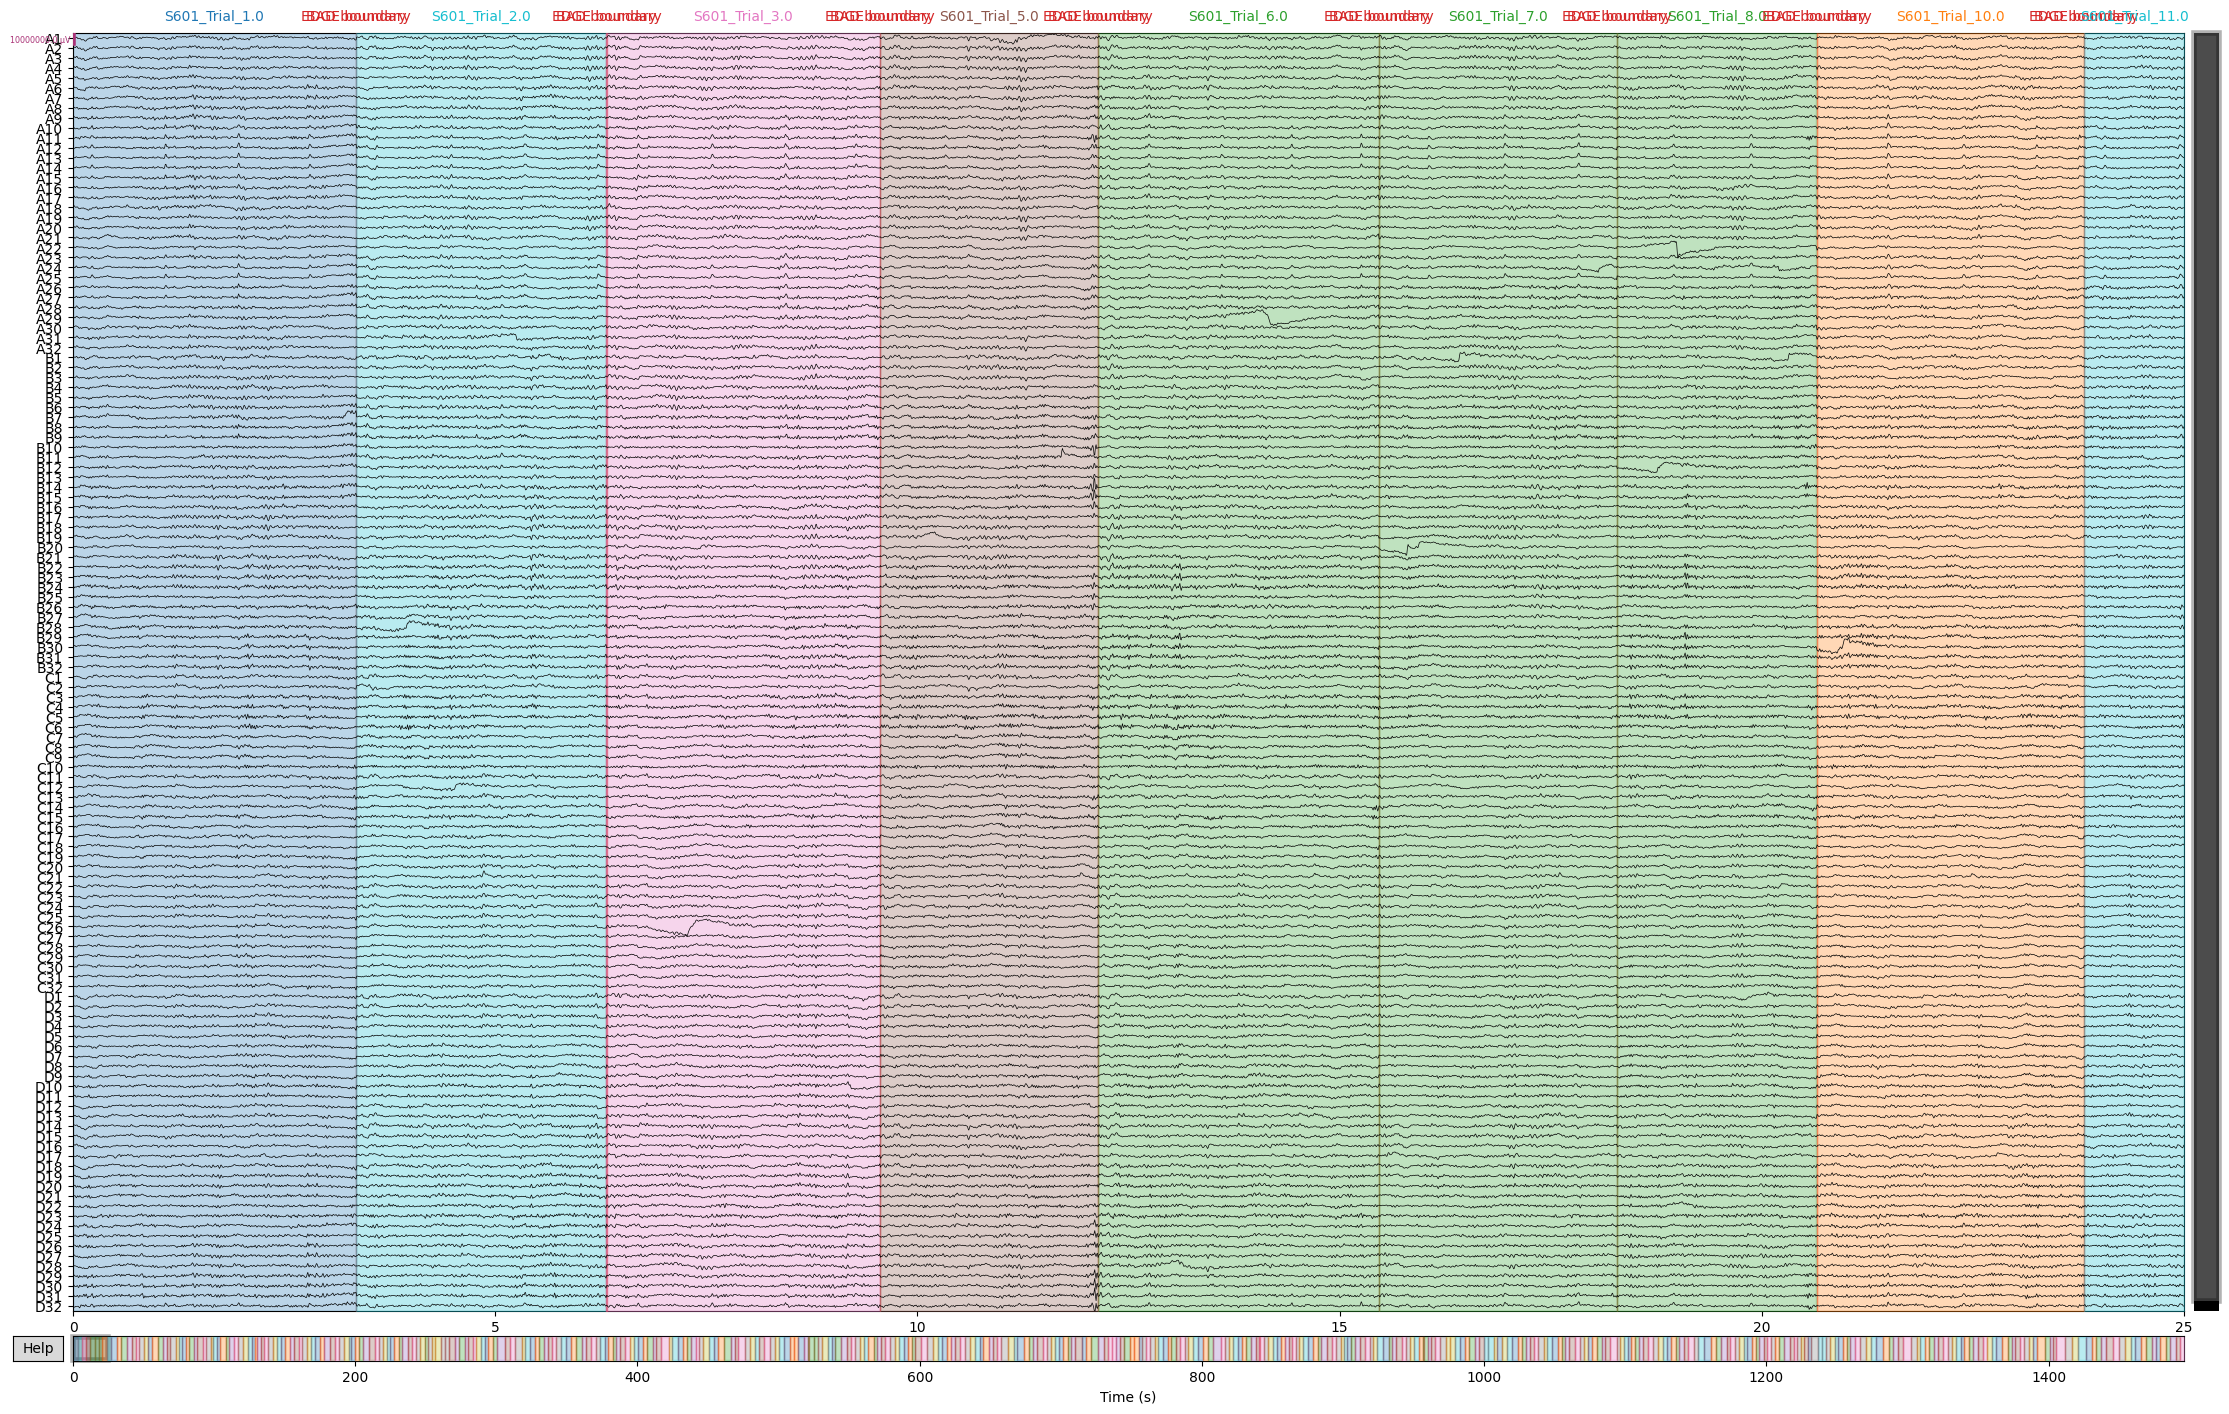

Channels marked as bad:
none


In [2]:
combined_pregICA_path = os.path.join(workspace_root, 'Data', 'combined_pregICA.fif')
combined_pregICA = mne.io.read_raw_fif(combined_pregICA_path, preload=True)
%matplotlib qt
combined_pregICA.plot(duration=25, n_channels=128, scalings= 5 )